In [47]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import gym


HIDDEN1_UNITS=256
HIDDEN2_UNITS=128
HIDDEN3_UNITS=64
HIDDEN4_UNITS=32


class cnn():
    def __init__(self, data_file,state_size=4,action_size=3,Testing=False):
     self.testing=Testing
     self.data= pd.read_csv(data_file)
     self.data['action']=(self.data['action']+2)/4
     self.data['cos_theta_old']=(self.data['cos_theta_old']+1)/2
     self.data['cos_theta']=(self.data['cos_theta']+1)/2
     self.data['sin_theta']=(self.data['sin_theta']+1)/2
     self.data['sin_theta_old']=(self.data['sin_theta_old']+1)/2
     self.data['theta_dot']=(self.data['theta_dot']+8)/16
     self.data['theta_dot_old']=(self.data['theta_dot_old']+8)/16
     #print('data is:',self.data)
     self.model = Net(state_size, action_size).float()
     self.optim = Adam(self.model.parameters(), lr=0.03)
     self.criterion= nn.MSELoss()
     
    def train(self,epoch) :
     batch_size=32
     data_len=self.data.shape[0]
     print('Size of data:',data_len)
     loss_track=[]
     running_loss = 0.0
     x=self.data[['action',"cos_theta_old","sin_theta_old","theta_dot_old"]].values
     y=self.data[["cos_theta","sin_theta","theta_dot"]].values
     for epo in range(epoch):
       for i in range(int(data_len/10)):
        rand_ids = np.random.randint(0, data_len, batch_size)
        #print("ids are ",rand_ids)
        self.optim.zero_grad()
        inputs, labels = x[rand_ids],y[rand_ids]
        #print("Inputs are:",inputs)
        #print("labels are:",labels)
        inputs=torch.from_numpy(inputs)
        labels=torch.from_numpy(labels).float()
        #print("type of imput",type(inputs))
        
        # forward + backward + optimize
        outputs = self.model(inputs.float())
        loss = self.criterion(outputs, labels)
        #print('loss is:',loss)
        loss.backward()
        self.optim.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %(epo + 1, i + 1, running_loss))
            loss_track.append(running_loss)
            running_loss = 0.0
     plt.figure()       
     plt.plot(loss_track,label='loss')
     plt.grid()
     plt.title('Displacement Value on stream of image data')
     plt.legend(loc="upper left")
     plt.show()
     
    def predict(self,data):
         #print('Data is:',data)
         data[0]=(data[0]+2)/4
         data[1]=(data[1]+1)/2
         data[2]=(data[2]+1)/2
         data[3]=(data[3]+8)/16
         test_data=torch.from_numpy(data).float()
         out=self.model(test_data)     
         return out.detach().numpy()
         
        
class Net(nn.Module):
    def __init__(self, state_size, action_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN1_UNITS)
        self.fc2 = nn.Linear(HIDDEN1_UNITS, HIDDEN2_UNITS)
        self.fc3 = nn.Linear(HIDDEN2_UNITS, HIDDEN3_UNITS)
        self.fc4 = nn.Linear(HIDDEN3_UNITS, HIDDEN4_UNITS)
        self.fc5 = nn.Linear(HIDDEN4_UNITS, action_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x



Size of data: 200000
[1,  2000] loss: 6.71004268
[1,  4000] loss: 1.71264991
[1,  6000] loss: 1.41191376
[1,  8000] loss: 1.22884041
[1, 10000] loss: 1.25160990
[1, 12000] loss: 1.41787661
[1, 14000] loss: 1.21783185
[1, 16000] loss: 1.10132873
[1, 18000] loss: 1.23443257
[1, 20000] loss: 1.42444889


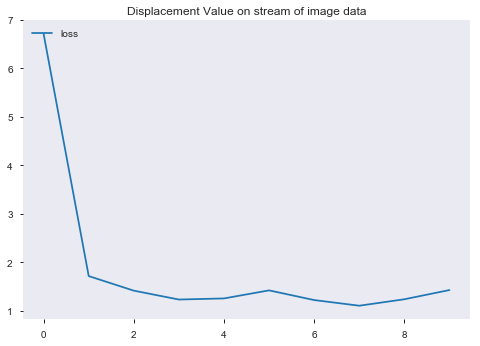

In [48]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 13 15:20:36 2020

@author: HPP
"""
import gym
import pandas as pd 
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from CNN import cnn


csvfile = "Pendulum-v0_dummy.csv"  #file name
neuralnet=cnn(csvfile)
neuralnet.train(1)

In [55]:
def test(sim_steps,d_step):
 env = gym.make('Pendulum-v0')
 env.reset() 
 pend_gym= []
 pend_sm=[]
 obs_old=np.zeros(3,)
 for k in range(sim_steps):
    #env.render()
    #select a random action in range of permissible action (+2 to -2)
    action=env.action_space.sample()
    action=action.astype('double')
    #action=(action+2)/4
    #print("type of action:",type(action))
    obs,reward,done,_=env.step(action) # take a random action and observe the state of system 
    if k%d_step==0:
     obs_old=obs
    y_predict = neuralnet.predict(np.concatenate((action,obs_old),axis=0))
    pend_gym.append(obs)
    pend_sm.append(y_predict)
    y_predict[0]=(y_predict[0]*2)-1
    y_predict[1]=(y_predict[1]*2)-1
    y_predict[2]=(y_predict[2]*16)-8
    obs_old=y_predict
    
 df_gym=pd.DataFrame(pend_gym,columns=['cos','sin','theta_dot'])
 df_sm=pd.DataFrame(pend_sm,columns=['cos','sin','theta_dot'])

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["theta_dot"],label='from gym')
 plt.plot(df_sm["theta_dot"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["cos"],label='from gym')
 plt.plot(df_sm["cos"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["sin"],label='from gym')
 plt.plot(df_sm["sin"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()


Running simulation with mass: 1.0


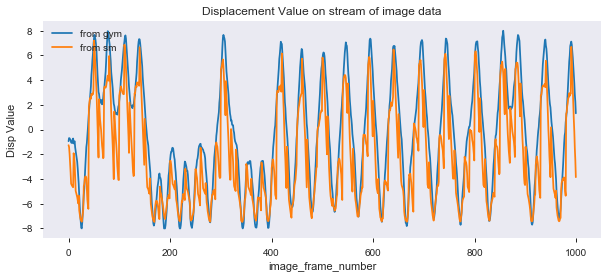

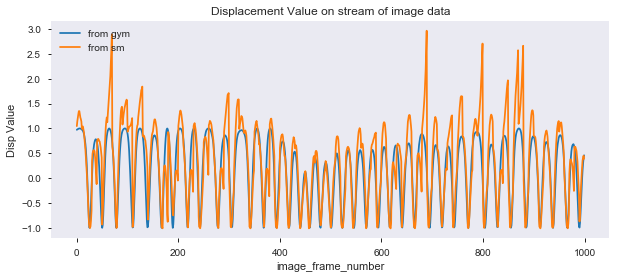

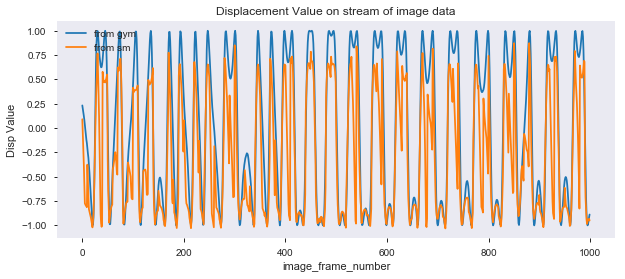

In [66]:
test(1000,10)